In [1]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionReactionModel as PDEModel #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.models import AdjointSimpleODEModel as ODEModel #Model module builds basic pa
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model
from advectionGP.wind import WindFixU #Wind model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# GPy: Gaussian processes library
import GPy

import scipy

#GPyOpt
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,3) # lower time
xloc=np.linspace(2,8,5) # x locations
yloc=np.linspace(2,8,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

XGP= np.zeros((sensN*obsN,3))
XGP[:,0] = (X[:,0]+X[:,1])/2
XGP[:,1] = X[:,2]
XGP[:,2] = X[:,3] 



sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

# generate sensor locations for test data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(2,9,5) # lower time
xloc=np.linspace(1.5,8.5,4) # x locations
yloc=np.linspace(1.5,8.5,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
Xtest= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
Xtest[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
Xtest[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
Xtest[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
Xtest[:,1] = Xtest[:,0]+1

XGPtest= np.zeros((sensN*obsN,3))
XGPtest[:,0] = (Xtest[:,0]+Xtest[:,1])/2
XGPtest[:,1] = Xtest[:,2]
XGPtest[:,2] = Xtest[:,3]

sensorsTest = FixedSensorModel(Xtest,1) # establish sensor model

In [3]:
k_0 = 0.01 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30,30] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.5
u=[]
u.append(np.ones(res)*0.01) #x direction wind
u.append(np.ones(res)*0.01) # y direction wind
windmodel=WindFixU(u)
#u.append(np.ones(res)*0.1) #x direction wind
#u.append(np.ones(res)*0.1) # y direction wind
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=(m.computeSourceFromPhi(z))# Compute source

In [4]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

m.sensormodel=sensorsTest
yTest= m.computeObservations() 

In [5]:
N_feat = 200
k2 = EQ(2, 2.0)
sigmaMCMC=0.5
out = []
var = np.ones(len(yTrain))*noiseSD**2
accept = 0 
mMCMC = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration
#zCur=np.random.normal(0,1.0,N_feat) # Generate z to compute source
zCur=np.ones(N_feat)
source = mMCMC.computeSourceFromPhi(zCur) # Generates estimated source using inferred distribution
conc=mMCMC.computeConcentration(source) # Compute test concentration
yMCMC= mMCMC.computeObservations(addNoise='TRUE') # Compute observations with noise
llObsCur = -0.5*np.sum((np.square(np.subtract(yTrain,yMCMC))/var)+ObsN*np.log(var)+ObsN*np.log(2*np.pi))
logPriorCur = 0
iterations=100000
out.append(zCur)
for j in zCur:
    logPriorCur += np.log(scipy.stats.norm(0, 1).pdf(j))
for i in range(iterations):
    zCan = zCur + np.random.normal(0,sigmaMCMC,N_feat)
    source = mMCMC.computeSourceFromPhi(zCan) # Generates estimated source using inferred distribution
    concCan=mMCMC.computeConcentration(source) # Compute test concentration
    yCan= mMCMC.computeObservations(addNoise='TRUE') # Compute observations with noise
    llObsCan = -0.5*np.sum((np.square(np.subtract(yTrain,yCan))/var)+0.5*np.log(var))
    logPriorCan = 0
    for j in zCan:
        logPriorCan += np.log(scipy.stats.norm(0, 1).pdf(j))
        
    logPiCan = llObsCan + logPriorCan
    logPiCur = llObsCur + logPriorCur
    u = np.random.uniform(0,1)
    
    if np.log(u) < logPiCan - logPiCur:
        zCur = zCan
        logPriorCur = logPriorCan
        accept += 1
    out.append(zCur)
        




NameError: name 'ObsN' is not defined

In [ ]:
plt.plot(np.transpose(out)[56])

In [ ]:
accept/iterations

In [ ]:
plt.plot(out)

In [ ]:
logPriorCan

In [ ]:
logPiCan - logPiCur

In [7]:
#%%timeit -r 4 -n 10
N_feat = 10
k2 = EQ(2, 2.0)
sigmaMCMC=0.005
out2 = []
var = np.ones(len(yTrain))*noiseSD**2
accept = 0 
#start_time2 = time.time()
#t_end = time.time() +54.8
iters = 0
ObsN=75

mMCMC = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration
#zCur=np.random.normal(0,1.0,N_feat) # Generate z to compute source
zCur=np.ones(N_feat)
source = mMCMC.computeSourceFromPhi(zCur) # Generates estimated source using inferred distribution
conc=mMCMC.computeConcentration(source) # Compute test concentration
yMCMC= mMCMC.computeObservations() # Compute observations with noise
#llObsCur = -0.5*np.sum((np.square(np.subtract(yTrain,yMCMC))/(noiseSD**2)))-0.5*ObsN*np.log(noiseSD**2)-0.5*ObsN*np.log(2*np.pi)
logPiCur = -np.inf
llObsCur = 0
iterations=20000
#out2.append(zCur)
#for zi in zCur:
#    logPriorCur += np.log(scipy.stats.norm(0, 1).pdf(zi))

for i in range(iterations):
    zCan = zCur + np.random.normal(0,sigmaMCMC,N_feat)
    source = mMCMC.computeSourceFromPhi(zCan) # Generates estimated source using inferred distribution
    concCan=mMCMC.computeConcentration(source) # Compute test concentration
    yCan= mMCMC.computeObservations() # Compute observations with noise
    llObsCan = -0.5*np.sum((np.square(np.subtract(yTrain,yCan))/(noiseSD**2)))-0.5*ObsN*np.log(noiseSD**2)-0.5*ObsN*np.log(2*np.pi)
    logPriorCan = 0
    for j in zCan:
        logPriorCan += np.log(scipy.stats.norm(0, 1).pdf(j))

    logPiCan = llObsCan + logPriorCan
    #logPiCur = llObsCur + logPriorCur
    #print(logPiCan,logPiCur)
    u = np.random.uniform(0,1)

    if np.log(u) < logPiCan - logPiCur:
        zCur = zCan
        #logPriorCur = logPriorCan
        logPiCur = logPiCan
        accept += 1
    out2.append(zCur)
    iters +=1
    #if time.time() > t_end:
        #break 
        
print(iters)

20000


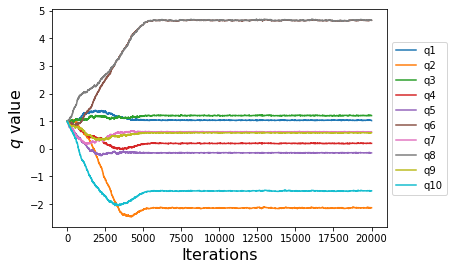

In [8]:
plt.plot(np.array(out2));
plt.xlabel("Iterations",fontsize=16)
plt.ylabel("$q$ value",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
tick_font_size =24
plt.legend(('q1','q2','q3','q4','q5','q6','q7','q8','q9','q10'),loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MCMC10.pdf',bbox_inches='tight') 


In [9]:
from scipy.stats import norm

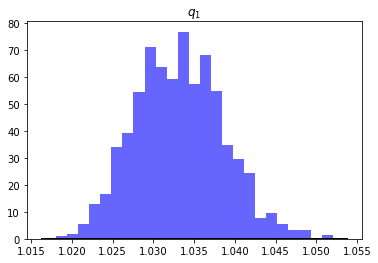

In [10]:
plt.hist(np.transpose(out2)[0][7000:],bins=25, density=True, alpha=0.6, color='b');
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, -3.62, np.sqrt(4.26e-4))
  
plt.plot(x, p, 'k', linewidth=2)
title = "$q_1$"
plt.title(title)
plt.savefig('MCMCq1.pdf',bbox_inches='tight') 

In [11]:
accept/iterations

0.1816

In [12]:
regressPDE = mMCMC.computeModelRegressors() # Compute regressor matrix
meanZMCMC, covZMCMC = mMCMC.computeZDistribution(yTrain) # Infers z vector mean and covariance

Calculating Adjoints...
74/75 
Calculating Phis...
9/10 


In [13]:
meanZMCMC

array([ 1.03362793, -2.14219921,  1.20151413,  0.1950627 , -0.14445207,
        4.6432965 ,  0.61346849,  4.65152679,  0.5790239 , -1.52634804])

In [14]:
np.diag(covZMCMC)

array([2.98832230e-05, 1.27454110e-04, 4.71442386e-05, 2.89617864e-05,
       1.73534423e-05, 2.09108267e-04, 1.99374061e-05, 2.28506069e-04,
       2.63635122e-05, 8.73008605e-05])

In [15]:
np.mean(np.asarray(out2)[10000:,:],0)

array([ 1.03318128, -2.14088862,  1.20321515,  0.1950411 , -0.14415255,
        4.6450887 ,  0.61347401,  4.65340361,  0.57876731, -1.52464363])

In [16]:
np.diag(np.cov(np.asarray(out2)[10000::10,:].T))

array([2.96056954e-05, 1.10319646e-04, 3.72166096e-05, 2.58767101e-05,
       1.74992654e-05, 1.45278586e-04, 1.83776670e-05, 1.60444702e-04,
       2.19035155e-05, 6.95252959e-05])

In [17]:
meanZ = np.mean(np.asarray(out2)[10000:,:],0)
covZ = np.cov(np.asarray(out2)[10000::10,:].T)
MSEsource = 0

for j in range(100):
    z = np.random.multivariate_normal(meanZ,covZ)
    sourceInfer = mMCMC.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
    MSEsource+=(np.square(np.subtract(sourceGT,sourceInfer))).mean()
    #RMSEsource[i,l]+=np.sqrt((np.square(np.subtract(source,sourceInfer))).mean())

In [18]:
MSEsource/100

3.307483895135882

In [19]:


import time
N_feat=100
k2 = EQ(2, 2.0) 
start_time1 = time.time()




print("2. Solving the backward pde--- %s seconds ---" % (time.time() - start_time1))

2. Solving the backward pde--- 0.0010178089141845703 seconds ---


In [20]:
%%timeit -r 4 -n 10
mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio

Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/100 
Calculating Adjoints...
74/75 
Calculating Phis...
99/10

In [21]:
193
195
144
171
200
200
192
194
150
158
197
188
200
185
185
180
192
184
177
168
200
200
200
200
200

200

In [67]:
#%%timeit -r 4 -n 10
N_feat = 100
k2 = EQ(2, 2.0)
sigmaMCMC=0.05
out3 = []
var = np.ones(len(yTrain))*noiseSD**2
accept = 0 
#start_time2 = time.time()
#t_end = time.time() +54.8
iters = 0
ObsN=75

mMCMC = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration
#zCur=np.random.normal(0,1.0,N_feat) # Generate z to compute source
zCur=np.ones(N_feat)
source = mMCMC.computeSourceFromPhi(zCur) # Generates estimated source using inferred distribution
conc=mMCMC.computeConcentration(source) # Compute test concentration
yMCMC= mMCMC.computeObservations() # Compute observations with noise
#llObsCur = -0.5*np.sum((np.square(np.subtract(yTrain,yMCMC))/(noiseSD**2)))-0.5*ObsN*np.log(noiseSD**2)-0.5*ObsN*np.log(2*np.pi)
logPiCur = -np.inf
llObsCur = 0
iterations=2000
out3.append(zCur)
#for zi in zCur:
#    logPriorCur += np.log(scipy.stats.norm(0, 1).pdf(zi))
zCan = zCur

out4=[]
for i in range(iterations): 
    for c in range(N_feat): 
        zCan = np.array(zCur)
        zCan[c] += np.random.normal(0,sigmaMCMC,1)
        #print(zCur,zCan)
        source = mMCMC.computeSourceFromPhi(zCan) # Generates estimated source using inferred distribution
        concCan=mMCMC.computeConcentration(source) # Compute test concentration
        yCan= mMCMC.computeObservations() # Compute observations with noise
        llObsCan = -0.5*np.sum((np.square(np.subtract(yTrain,yCan))/(noiseSD**2)))-0.5*ObsN*np.log(noiseSD**2)-0.5*ObsN*np.log(2*np.pi)
        logPriorCan=0
        for j in zCan:
            logPriorCan += np.log(scipy.stats.norm(0, 1).pdf(j))

        logPiCan = llObsCan + logPriorCan
        #print(logPiCan,logPiCur)
        #logPiCur = llObsCur + logPriorCur
        u = np.random.uniform(0,1)
        if np.log(u) < logPiCan - logPiCur:
            zCur[c] = zCan[c]
            
            #print("yes")
            #logPriorCur = logPriorCan
            logPiCur = logPiCan
            accept += 1
            #print("yes")
        
        
        out3.append(np.array(zCur))

In [68]:
accept/(iterations*N_feat)

0.374175

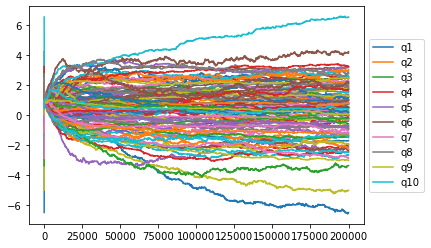

In [69]:
plt.plot(out3)
plt.legend(('q1','q2','q3','q4','q5','q6','q7','q8','q9','q10'),loc='center left', bbox_to_anchor=(1, 0.5))

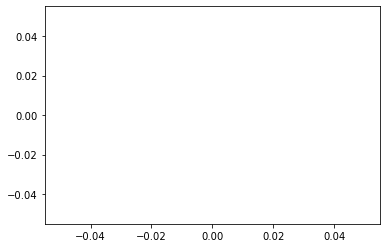

In [70]:
plt.plot(out4)

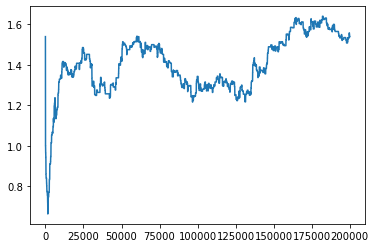

In [71]:
plt.plot(np.transpose(out3)[4]);

In [52]:
np.array(out3).shape

(20001, 10)